# 0 Packages und Datensatz laden

In [1]:
import pandas as pd
import os
import gc
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
date_list = ["201801", "201802",  "201803", "201804", "201805", "201806", "201807", "201808", "201809", "201810", "201811", "201812"]
df_list = []

for d in date_list:
  os.system(f'wget https://s3.amazonaws.com/tripdata/{d}-citibike-tripdata.csv.zip >/dev/null 2>&1')
  os.system(f'unzip {d}-citibike-tripdata.csv.zip >/dev/null 2>&1')

  df_list.append(pd.read_csv(f"{d}-citibike-tripdata.csv"))

  os.system(f'rm {d}-citibike-tripdata.csv.zip')
  os.system(f'rm {d}-citibike-tripdata.csv')


df = pd.concat(df_list, ignore_index=True)

#Remove space
del df_list
gc.collect();

# 1 Ein Überblick über den Datensatz

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start station id         float64
 4   start station name       object 
 5   start station latitude   float64
 6   start station longitude  float64
 7   end station id           float64
 8   end station name         object 
 9   end station latitude     float64
 10  end station longitude    float64
 11  bikeid                   int64  
 12  usertype                 object 
 13  birth year               int64  
 14  gender                   int64  
dtypes: float64(6), int64(4), object(5)
memory usage: 2.0+ GB


--> Der Datensatz hat 14 Spalten, wovon usertype die Zielvariable ist. Es gibt 5 diskrete Spalten, 6 Float und 5 Int 

In [4]:
#Erster Blick auf den Datensatz
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,W 52 St & 11 Ave,40.767272,-73.993929,505.0,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3255.0,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,W 52 St & 11 Ave,40.767272,-73.993929,525.0,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,W 52 St & 11 Ave,40.767272,-73.993929,447.0,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3356.0,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1


In [5]:
#Null-Werte prüfen
df.isna().sum()/len(df)

tripduration               0.000000
starttime                  0.000000
stoptime                   0.000000
start station id           0.000142
start station name         0.000142
start station latitude     0.000000
start station longitude    0.000000
end station id             0.000142
end station name           0.000142
end station latitude       0.000000
end station longitude      0.000000
bikeid                     0.000000
usertype                   0.000000
birth year                 0.000000
gender                     0.000000
dtype: float64

→ für einen sehr geringen Anteil gibt es keine Informationen zur Start Station ID bzw. der End Station ID. Der Datensatz scheint also kein großes Problem mit fehlenden Daten zu haben

<AxesSubplot:ylabel='usertype'>

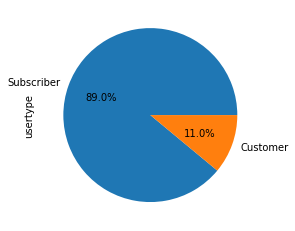

In [6]:
#Wie ist die Zielvariable verteilt?

df["usertype"].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')

→ Der Großteil der Fahrten wurde von Subscribern (jährliche Mitgliedschaft) durchgeführt, nur 11% der Fahrten wurden von Customer (24 Stunden/ 3 Tage Pass) durchgeführt
→ Es ist somit einfacher für die Interpretation die Variable Customer als 1 und Subscriber als 0 zu codieren

# 2 Datentransformationen

Basierend auf der ersten Sichtung der Daten, werden ein paar einfache Transformationen durchgeführt:

* Für die fehlenden Station IDs wird 0 eingesetzt, ein besseres Verfahren zur Missing Data Imputation lohnt sich wegen der geringen Fallzahl nicht
* Die Station-IDs werden anschließend in den Datentyp Object geändert da es sich nicht um interpretierbare Zahlen handelt
* Die Usertype Variable wird in 1/0 codiert, wobei Customer=1 gesetzt wird und Subscriber=0
* Gender wird codiert, Informationen wie die Variable zu codieren ist, habe ich gegoogelt
* Darüber hinaus werden bereits hier 2 Transformationen der Daten voirgenommen, die die explorative Datenanalyse erleichtern:
    * Das Geburtsjahr wird in das einfacher zu interpretierende Alter umgewandelt
    * Die Timestamps der Startzeit sind für ein ML Model schwer zu nutzen, daher werden die relevanten Aspekte extrahiert: Datum, Monat, Wochentag & Stunde der Uhrzeit
* Aus den Koordinaten der Start & End Station kann man die zurückgelegte Distanz berechnen. Daraus kann auch die Variable meters_per_second abgeleitet werden
* Da der Datensatz relativ viel Memory belegt, werden einige Datentypen geändert und folgende Spalten gelöscht, die nicht mehr benötigt werden:
    * starttime → bereits transformiert
    * stoptime → bereits transformiert
    * start station name → keine Aussagekraft, Information ist in station_id enthalten
    * end station name → keine Aussagekraft, Information ist in station_id enthalten
    * bikeid → keine Aussagekraft erwartet
    * birth year → bereits transformiert

## 2.1 NA Werte auffüllen

In [7]:
print(df["start station id"].min())
print(df["end station id"].min())

print(df["start station id"].max())
print(df["end station id"].max())

72.0
72.0
3721.0
3721.0


In [8]:
#Für fehlende start station id und end station id wird der Wert 0 eingesetzt
df["start station id"].fillna(value=0, inplace=True)
df["end station id"].fillna(value=0, inplace=True)

## 2.2 Datenformate der Stations anpassen

In [9]:
#Station IDs sollen als Objects codiert werden
df["start station id"] = df["start station id"].astype("object")
df["end station id"] = df["end station id"].astype("object")

## 2.3 Usertype & Gender codieren

In [10]:
#Die Zielspalkte wird als 1/0 Wert codiert, wobei 
df["usertype"] = np.where(df["usertype"]  == "Customer", 1, 0)

In [11]:
df["gender"] = df["gender"].map({0: "unknown", 1: "male", 2: "female"})

## 2.3 Datentransformationen von age & starttime für bessere Interpretierbarkeit

In [12]:
# Das Alter ist aussagekräftiger und leichter zu interpretieren als das Geburtsjahr der Person:
df["age"] = pd.to_datetime(df["starttime"]).dt.year - df["birth year"]

print(df["age"].max())


print(df["age"].max())
print(df["age"].min())

133
133
16


In [13]:
# Das Ausleihdatum ist an sich nicht sehr aussagekfräftig. Wir extrahieren daher Datum, Monat und Stunde aus der Zeitangabe des Startdatums
df["date_"] = pd.to_datetime(df["starttime"]).dt.date
df["month"] = pd.to_datetime(df["starttime"]).dt.month
df["weekday"] = pd.to_datetime(df["starttime"]).dt.day_name()
df["time_hours"] = pd.to_datetime(df["starttime"]).dt.hour

In [14]:
df[["starttime", "date_", "month", "weekday", "time_hours"]].head()

,starttime,date_,month,weekday,time_hours
0,2018-01-01 13:50:57.4340,2018-01-01,1,Monday,13
1,2018-01-01 15:33:30.1820,2018-01-01,1,Monday,15
2,2018-01-01 15:39:18.3370,2018-01-01,1,Monday,15
3,2018-01-01 15:40:13.3720,2018-01-01,1,Monday,15
4,2018-01-01 18:14:51.5680,2018-01-01,1,Monday,18


## 2.4 neue Variable: distance_travelled_m & meters_per_second

In [15]:
#Aus den Daten der Start und Endstation können zwei weitere Variablen generiert werden:
#Berechnung der Distanz als Manhatten Distanz. Die Multiplikation mit 111139 kann laut https://sciencing.com/convert-distances-degrees-meters-7858322.html genutzt werden um Lat & Long in m umzurechnen
#Dies kann hilfreich sein, da erwartet werden kann, dass Subscriber längere Strecken zurücklegen
df["distance_travelled_m"] = np.abs(df["start station latitude"] - df["end station latitude"])*111139 + np.abs(df["start station longitude"] - df["end station longitude"])*111139

#Indem die Distanz durch die Zeit geteilt wird, kann die durchschnittliche Geschwindigkeit berechnet werden
df["meters_per_second"] = df["distance_travelled_m"]/df["tripduration"]

## 2.4 Memory Footprint des Datensatzes optimieren

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 22 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start station id         object 
 4   start station name       object 
 5   start station latitude   float64
 6   start station longitude  float64
 7   end station id           object 
 8   end station name         object 
 9   end station latitude     float64
 10  end station longitude    float64
 11  bikeid                   int64  
 12  usertype                 int64  
 13  birth year               int64  
 14  gender                   object 
 15  age                      int64  
 16  date_                    object 
 17  month                    int64  
 18  weekday                  object 
 19  time_hours               int64  
 20  distance_travelled_m     float64
 21  meters

In [17]:
#Memory Footprint durch Datenformate reduzieren
df["start station latitude"] = df["start station latitude"].astype("float32")
df["start station longitude"] = df["start station longitude"].astype("float32")
df["end station latitude"] = df["start station latitude"].astype("float32")
df["end station longitude"] = df["start station longitude"].astype("float32")
df["distance_travelled_m"] = df["distance_travelled_m"].astype("float32")
df["meters_per_second"] = df["meters_per_second"].astype("float32")

df["tripduration"] = df["tripduration"].astype("int32")
df["usertype"] = df["usertype"].astype("int8")
df["month"] = df["month"].astype("object")
df["time_hours"] = df["time_hours"].astype("object")
df["age"] = df["age"].astype("int32")

In [18]:
# Löschung nicht mehr benötigter Spalten
del df["starttime"]
del df["stoptime"]
del df["start station name"]
del df["end station name"]
del df["birth year"]
del df["bikeid"]


gc.collect();

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 16 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int32  
 1   start station id         object 
 2   start station latitude   float32
 3   start station longitude  float32
 4   end station id           object 
 5   end station latitude     float32
 6   end station longitude    float32
 7   usertype                 int8   
 8   gender                   object 
 9   age                      int32  
 10  date_                    object 
 11  month                    object 
 12  weekday                  object 
 13  time_hours               object 
 14  distance_travelled_m     float32
 15  meters_per_second        float32
dtypes: float32(6), int32(2), int8(1), object(7)
memory usage: 1.5+ GB


# 3 Data Exploration

Die Visualisierung der Daten erfolgt in 3 Gruppen:

1. Diskrete Variablen: start station id, end station id & gender
2. Zeit Variablen: date_, month, weekday, time_hours
3. Numerische Variablen: tripduration, distance_travelled_m, meters_pers_second

## 3.1 Diskrete Variablen:

In [20]:
discrete = ["start station id", "end station id",  "gender"]

### 3.1.1 Charakteristika der Variablen

In [21]:
for var in discrete:

  n_distinct = len(df[var].unique())
  print(f"Variable {var} hat {n_distinct} eindeutige Werte")

Variable start station id hat 819 eindeutige Werte
Variable end station id hat 851 eindeutige Werte
Variable gender hat 3 eindeutige Werte


### 3.1.2 Verteilung der Variablen

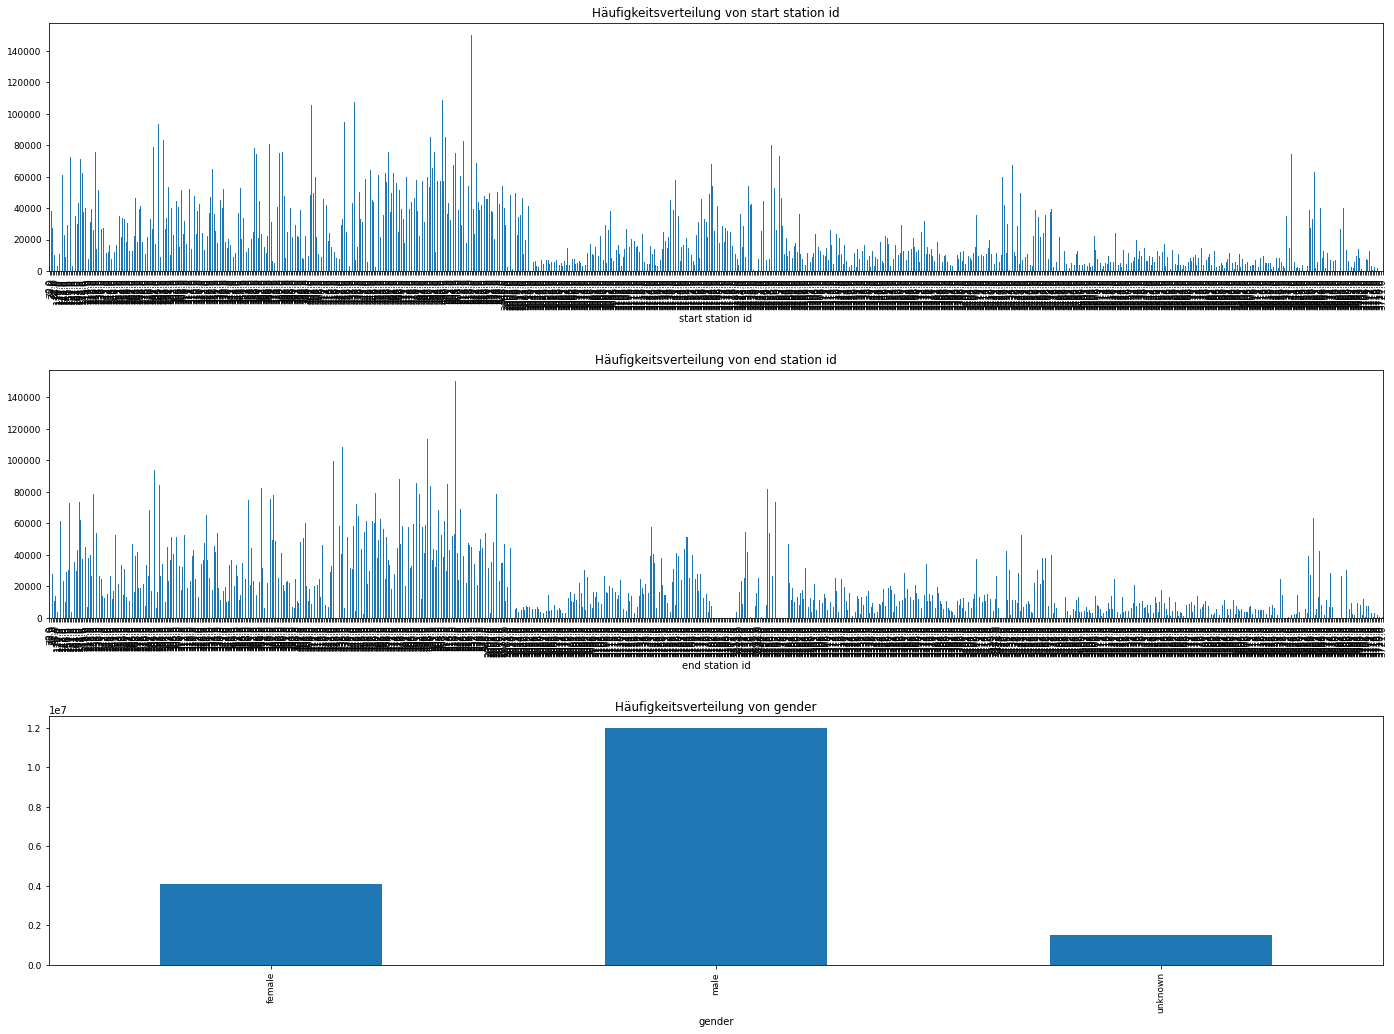

In [22]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axes = plt.subplots(nrows=3, ncols=1)

for var in discrete:
  df.groupby(var)["usertype"].count().plot.bar(ax=axes[discrete.index(var)], title=f"Häufigkeitsverteilung von {var}", fontsize=9)

fig.tight_layout(pad=3)

Erkentnisse:
* die start & end station ids mit kleinen Nummern kommen deutlich häufiger vor als diejenigen mit großen Nummern. Wahrscheinlich handelt es sich um die häufiger genutzten Stations im Zentrum
* Es fahre deutlich mehr Männer als Frauen. Es gibt eine deutliche Anzahl an Missing data bzgl. dem Geschlecht

### 3.1.3 Univariater Einfluss auf abhängige Variable

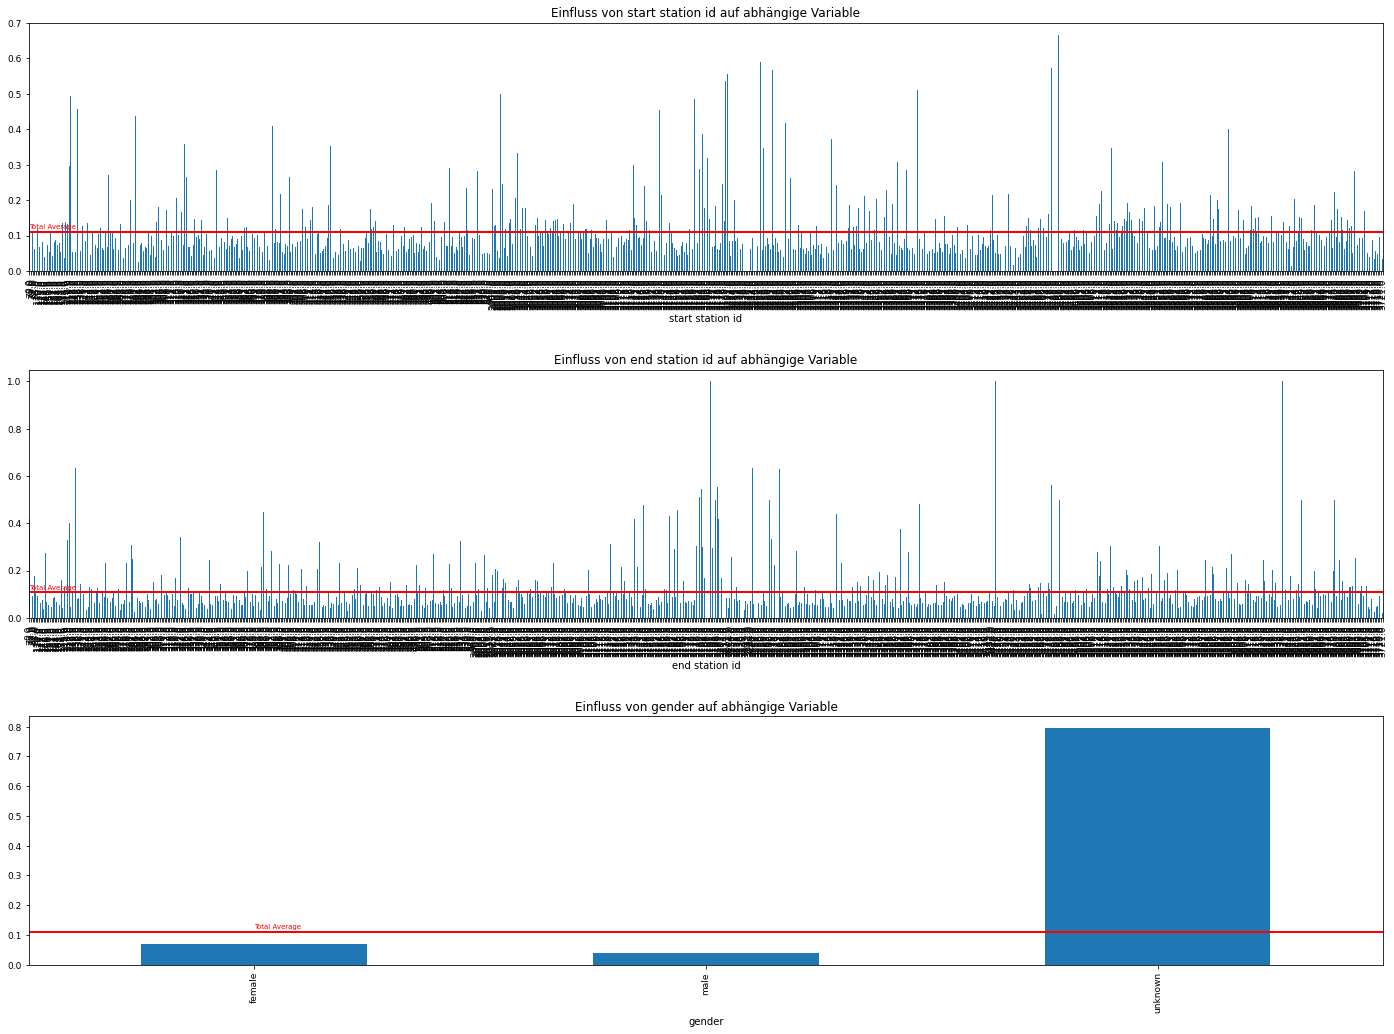

In [23]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axes = plt.subplots(nrows=3, ncols=1)

for var in discrete:
  bar_plot = df.groupby(var)["usertype"].mean().plot.bar(ax=axes[discrete.index(var)], title=f"Einfluss von {var} auf abhängige Variable", fontsize=9)
  bar_plot.axhline(y=df["usertype"].mean(), color= 'red', linewidth=2,)
  axes[discrete.index(var)].annotate("Total Average", xy=(0, 0.12), xytext=(0, 0.12), color="red", fontsize=7)

fig.tight_layout(pad=3)

Erkentnisse:
* Bestimmte start und end station IDs werden überproportional von customern genutzt
* Der Anteil an customern ist unter den fehlenden Geschlechtsinformationen sehr hoch. Daneben ist der customer Anteil der Frauen höher als bei den Männern.
* Es liegt nahe, dass customer die Angabe zum Geschlecht häufig nicht angeben

In [24]:
gc.collect();

### 3.1.4 Fahrverhalten genauer ansehen

Wir schauen uns nun an wie das Fahverhalten zwischen verschiedenen Stations aussieht und ob bestimmte Routen von customern häufiger genutzt werden. Dazu wird eine Heatmap zwischen Start & End Stations gezeichnet

In [25]:
#Vorbereitung der Daten
start_to_end_station = df.groupby(["start station id", "end station id"], as_index=False).agg(SUM_Usertype=('usertype', np.sum),Count=('usertype', np.size), AVG_Tripduration = ('tripduration', np.mean) , AVG_distance = ('distance_travelled_m', np.mean))

start_to_end_station["Count"] = np.log(start_to_end_station["Count"])
start_to_end_station["SUM_Usertype"] = np.log(start_to_end_station["SUM_Usertype"])
#start_to_end_station["AVG_Tripduration"] = np.log(start_to_end_station["AVG_Tripduration"])
#start_to_end_station["AVG_distance"] = np.log(start_to_end_station["AVG_distance"])

start_to_end_station.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,start station id,end station id,SUM_Usertype,Count,AVG_Tripduration,AVG_distance
0,0.0,0.0,6.948897,7.822845,2876.215058,952.982422
1,72.0,72.0,5.533389,6.754604,1376.593240,0.000000
2,72.0,79.0,1.098612,3.912023,1665.480000,6767.739258
3,72.0,82.0,-inf,0.000000,2346.000000,6927.801758
4,72.0,127.0,3.258097,5.513429,1314.915323,5375.055664


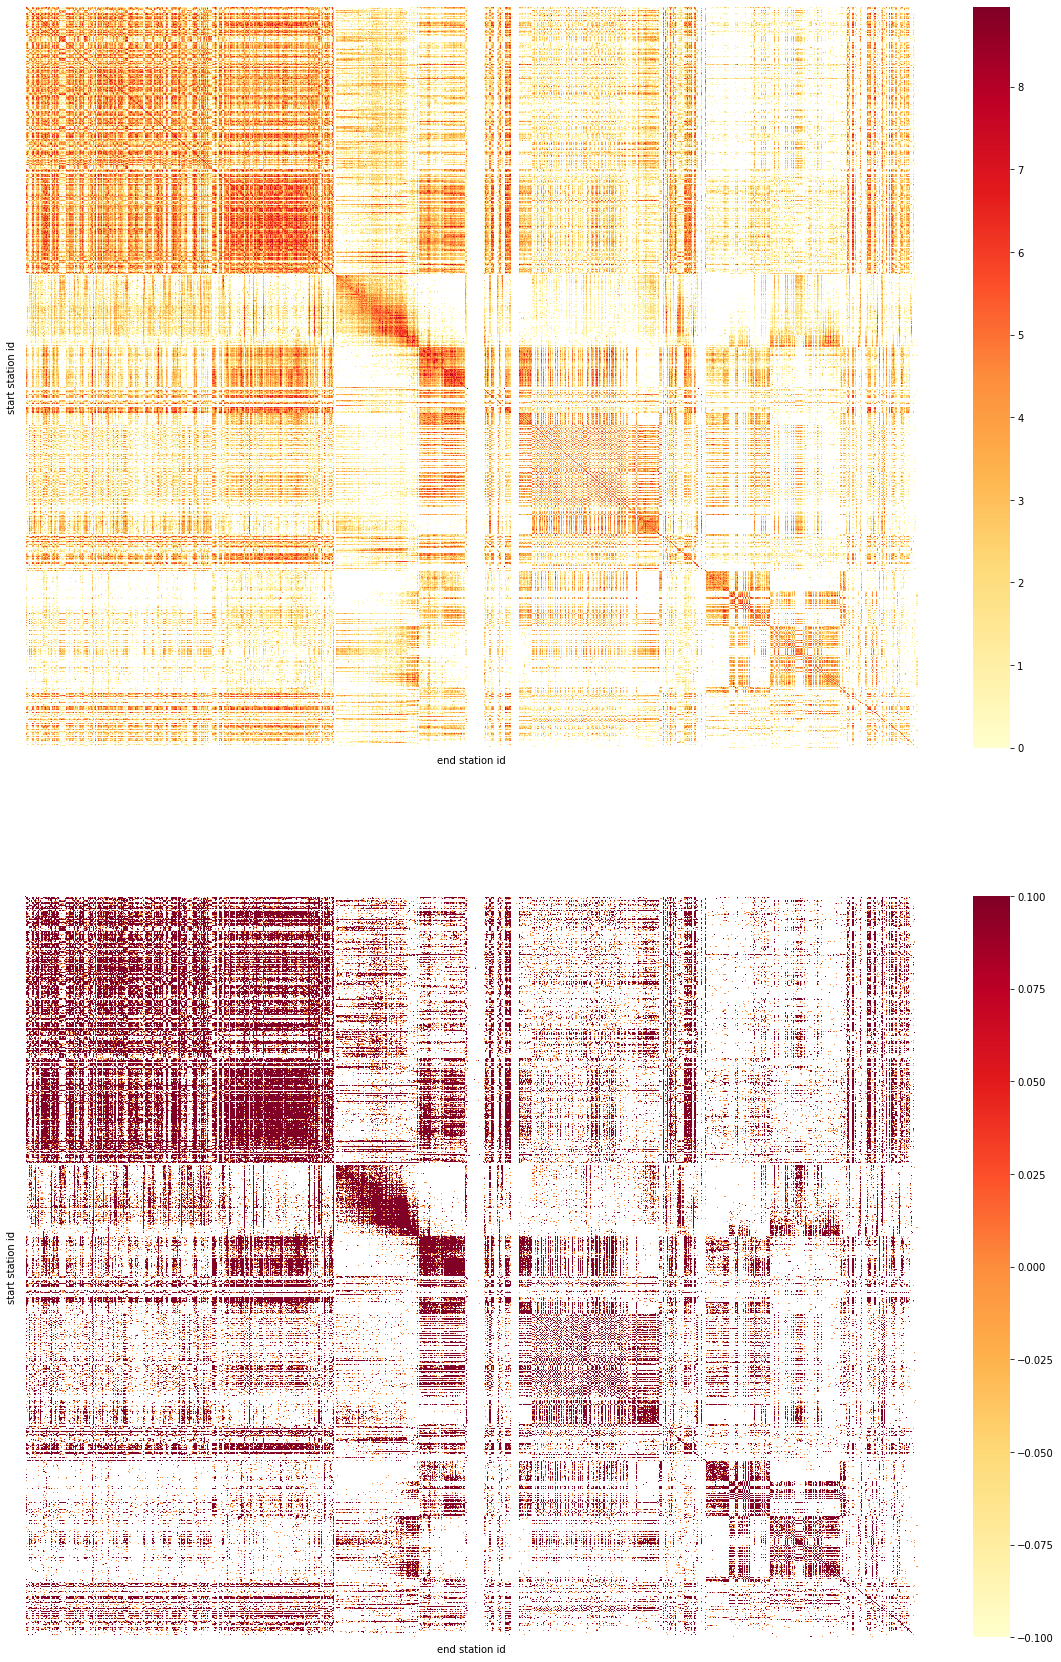

In [26]:
plt.rcParams["figure.figsize"] = (20,30)
fig, axes = plt.subplots(nrows=2, ncols=1)

sns.heatmap(pd.pivot_table(start_to_end_station, index="start station id", columns="end station id", values="Count"), cmap="YlOrRd", xticklabels=False, yticklabels=False, ax=axes[0])
sns.heatmap(pd.pivot_table(start_to_end_station, index="start station id", columns="end station id", values="SUM_Usertype"), cmap="YlOrRd", xticklabels=False, yticklabels=False, ax=axes[1])
#sns.heatmap(pd.pivot_table(start_to_end_station, index="start station id", columns="end station id", values="AVG_Tripduration"), cmap="BuPu", xticklabels=False, yticklabels=False, ax=axes[2])
#sns.heatmap(pd.pivot_table(start_to_end_station, index="start station id", columns="end station id", values="AVG_distance"), cmap="BuPu", xticklabels=False, yticklabels=False, ax=axes[3])


del start_to_end_station
gc.collect();

Erkentnisse:
* Die diagonale Linien in der ersten Heatmap deutet darauf hin, dass es Trips häufig die gleiche start & end station haben
* Da diese Linie in beiden Charts sehr ausgeprägt ist
* Die untere Heatmap hat deutlich mehr weiße Flecken und die Trips sind stärker auf wenige Strecken konzentriert (mehr rot, weniger gelb)

Es kann eine neue Variable getestet werden: start_end_same die angibt ob das Fahrrad bei der gleichen Station zurückgegeben wurde wo es ausgeliehen wurde

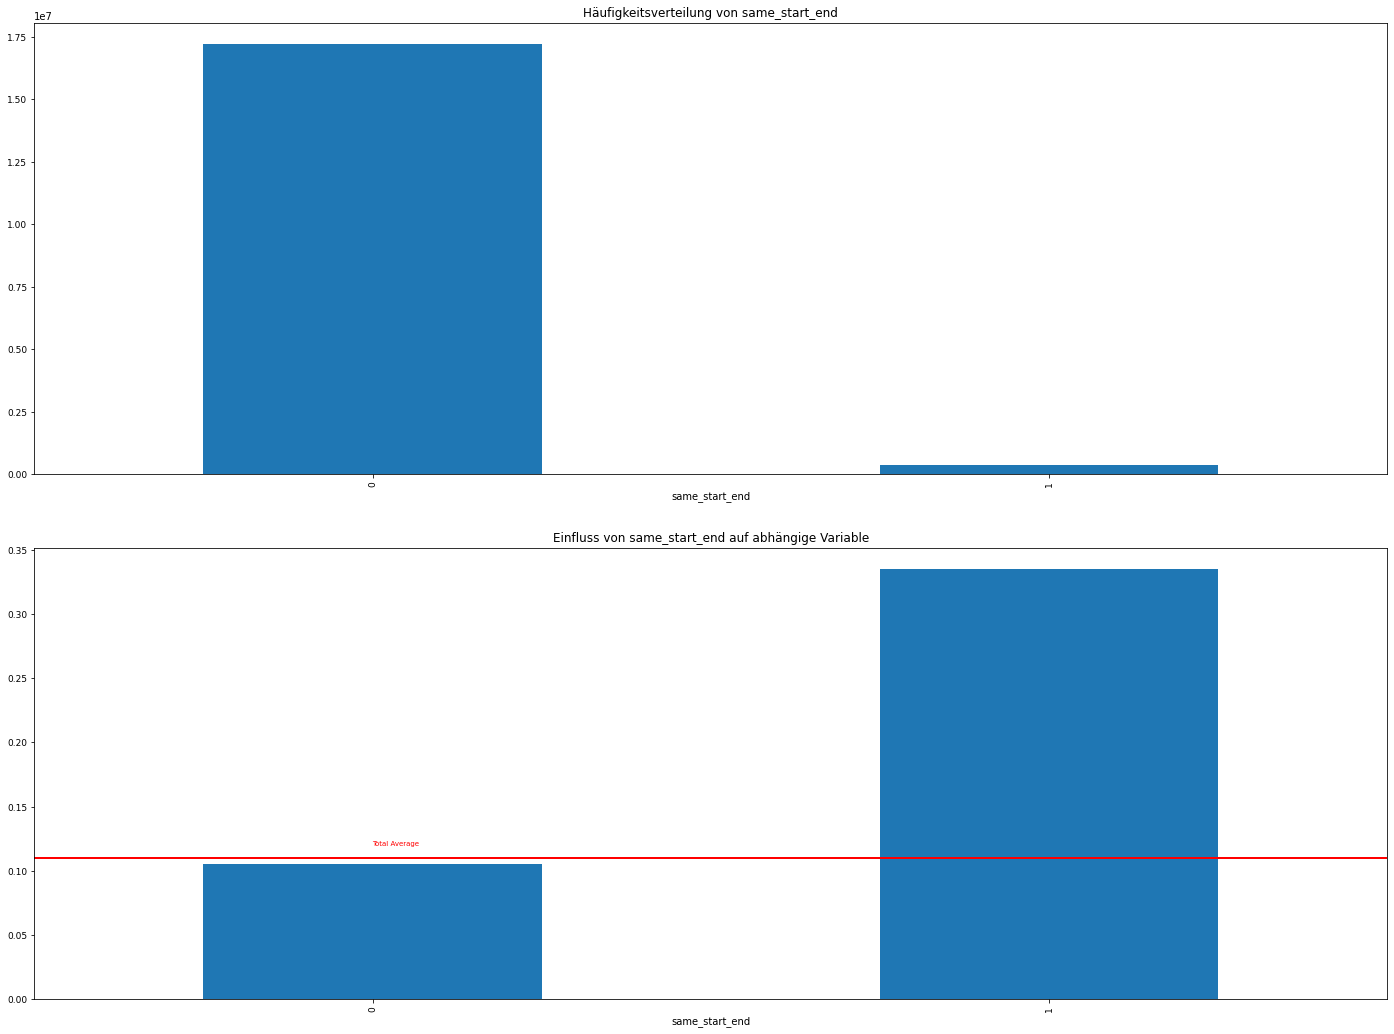

In [27]:
df["same_start_end"] = np.where(df["start station id"]  == df["end station id"], 1, 0)

plt.rcParams["figure.figsize"] = (20,15)
fig, axes = plt.subplots(nrows=2, ncols=1)

df.groupby("same_start_end")["usertype"].count().plot.bar(ax=axes[0], title=f"Häufigkeitsverteilung von same_start_end", fontsize=9)
bar_plot = df.groupby("same_start_end")["usertype"].mean().plot.bar(ax=axes[1], title=f"Einfluss von same_start_end auf abhängige Variable", fontsize=9)
bar_plot.axhline(y=df["usertype"].mean(), color= 'red', linewidth=2,)
axes[1].annotate("Total Average", xy=(0, 0.12), xytext=(0, 0.12), color="red", fontsize=7)

fig.tight_layout(pad=3)



→ Obwohl die Variable im Vergleich zu allen eine eher geringe Häufigkeit hat, könnte sie ein guter Prediktor für customer sein

## 3.2 Zeit Variablen:

In [28]:
time = ["date_", "month", "weekday", "time_hours"]

### 3.2.1 Charakteristika der Variablen

In [29]:
for var in time:

  n_distinct = len(df[var].unique())
  print(f"Variable {var} hat {n_distinct} eindeutige Werte")

Variable date_ hat 365 eindeutige Werte
Variable month hat 12 eindeutige Werte
Variable weekday hat 7 eindeutige Werte
Variable time_hours hat 24 eindeutige Werte


### 3.2.2 Verteilung der Variablen

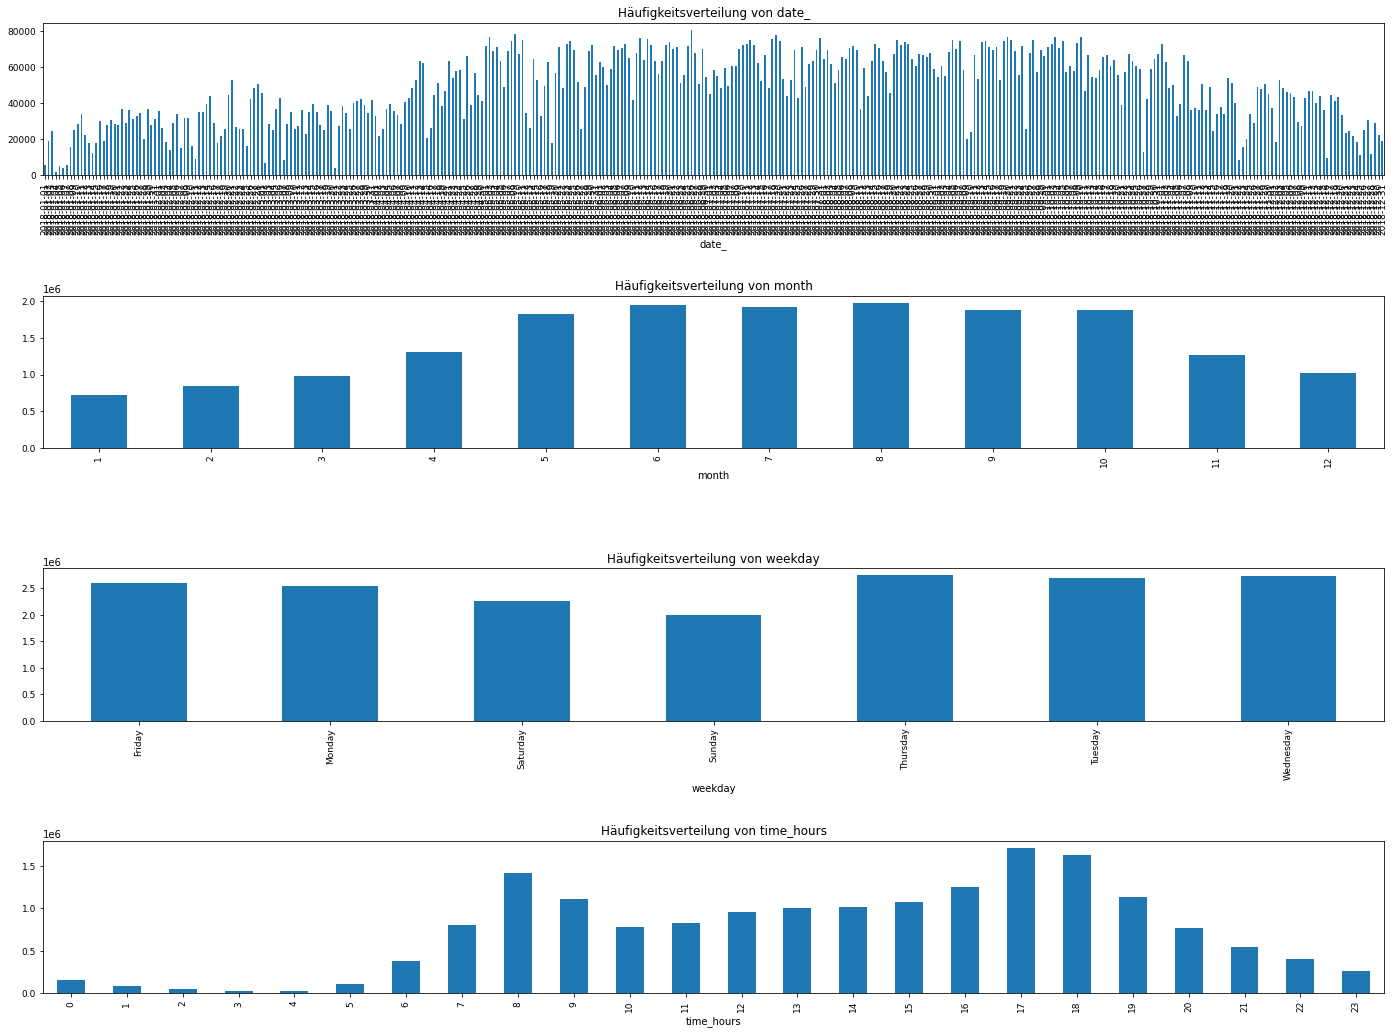

In [30]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axes = plt.subplots(nrows=4, ncols=1)

for var in time:
  df.groupby(var)["usertype"].count().plot.bar(ax=axes[time.index(var)], title=f"Häufigkeitsverteilung von {var}", fontsize=9)

fig.tight_layout(pad=3)

Erkentnisse:
* Die Nutzung der citibikes ist in den Sommer/Herbst Monaten höher als im Rest des Jahres
* An Wochentagen ist die Nutzung höher als am Wochenende
* Es gibt Peaks in der Nutzung zu Pendlerzeiten (8-9 Uhr und 17-18 Uhr)

### 3.2.3 Univariater Einfluss auf abhängige Variable

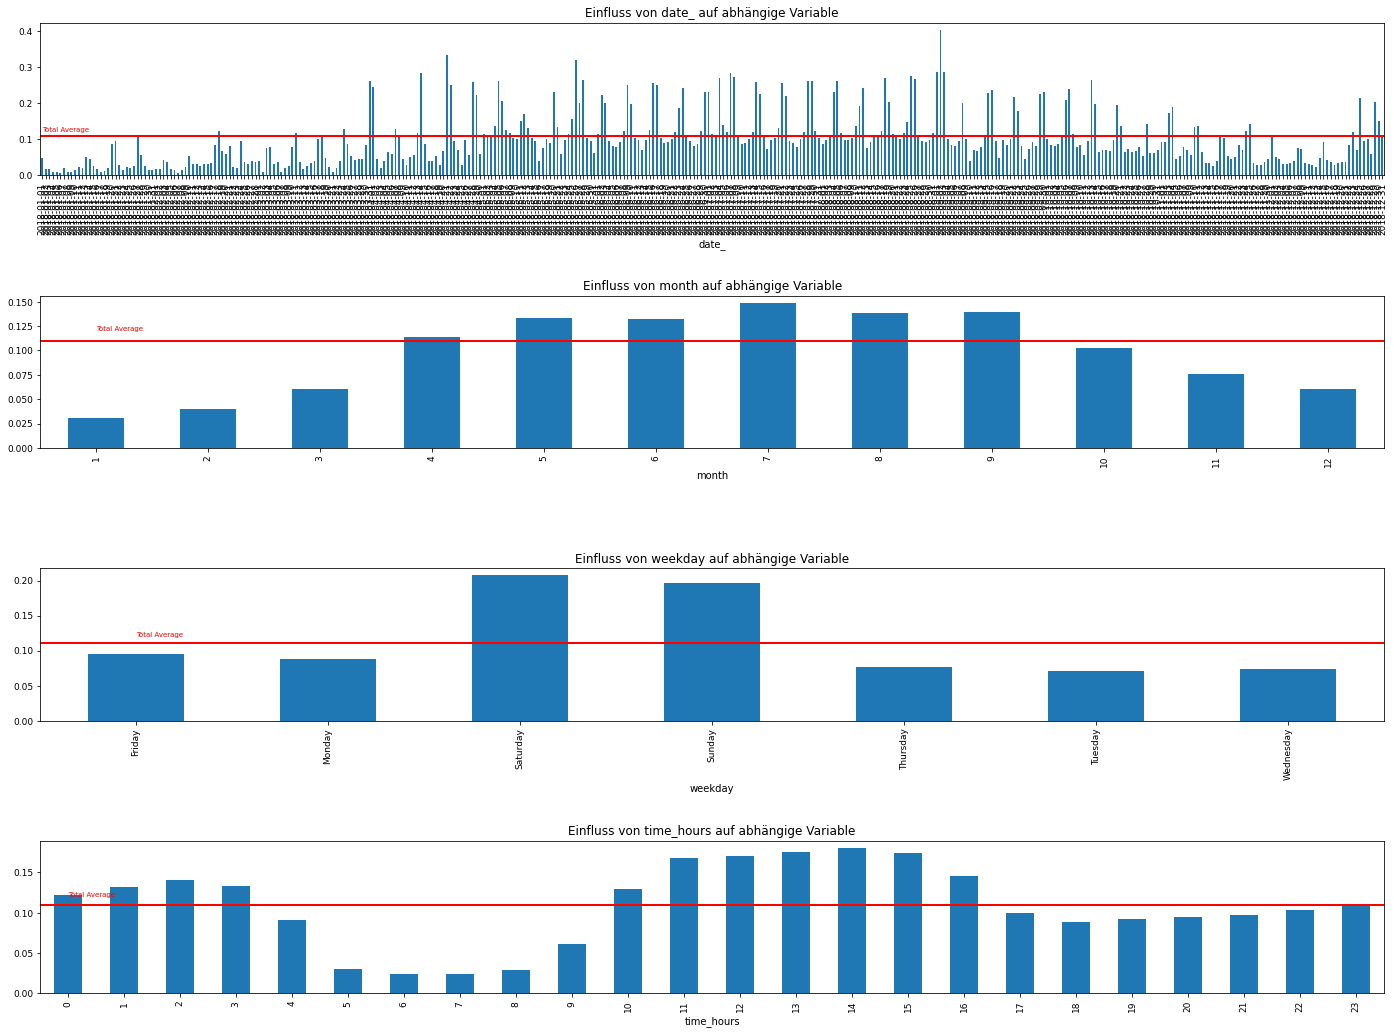

In [31]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axes = plt.subplots(nrows=4, ncols=1)

for var in time:
    bar_plot = df.groupby(var)["usertype"].mean().plot.bar(ax=axes[time.index(var)], title=f"Einfluss von {var} auf abhängige Variable", fontsize=9)
    bar_plot.axhline(y=df["usertype"].mean(), color= 'red', linewidth=2)
    axes[time.index(var)].annotate("Total Average", xy=(0, 0.12), xytext=(0, 0.12), color="red", fontsize=7)

fig.tight_layout(pad=3)

Erkentnisse:
* Der Anteil an customer wird in den Frühlings- & Sommermonaten höher. Im Winter sinkt der Anteil rapide
* Am Wochenende ist der Anteil der customner deutlich höher
* Der Anteil der customer ist in nicht-Pendler Zeiten höher als sonst. Besonders zwischen 11 und 16 Uhr. Wahrscheinlich Touristen in NYC

### 3.2.4 Da die Siasonalität der customer stark von der Pendlertätigkeit und dem Tourismus abzuhängen scheint, macht es Sinn die Feiertage ranzuspielen

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()

df["is_holiday"] = np.where(df["date_"].isin(calendar.holidays(start="1970-01-01", end="2100-12-30").date), 1, 0)
df["is_holiday"] = df["is_holiday"].astype("int8")

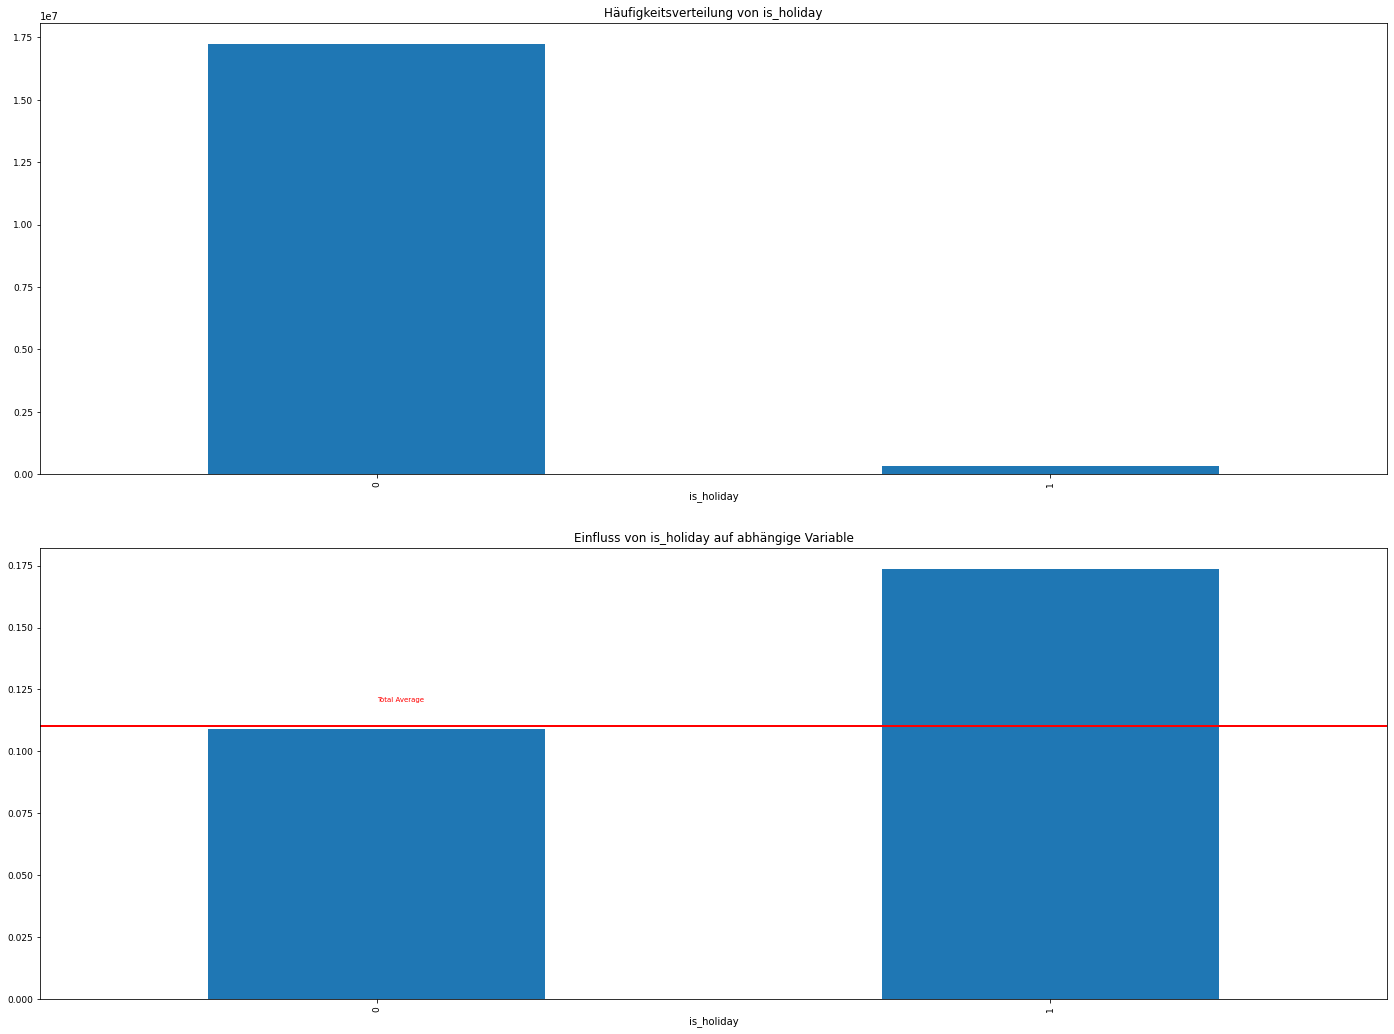

In [33]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axes = plt.subplots(nrows=2, ncols=1)

df.groupby("is_holiday")["usertype"].count().plot.bar(ax=axes[0], title=f"Häufigkeitsverteilung von is_holiday", fontsize=9)
                                                      
bar_plot = df.groupby("is_holiday")["usertype"].mean().plot.bar(ax=axes[1], title=f"Einfluss von is_holiday auf abhängige Variable", fontsize=9)
bar_plot.axhline(y=df["usertype"].mean(), color= 'red', linewidth=2)
axes[1].annotate("Total Average", xy=(0, 0.12), xytext=(0, 0.12), color="red", fontsize=7)

fig.tight_layout(pad=3)

--> Der Anteil an Feiertagen ist relativ gering, aber sie scheinen einen kleinen Einfluss auf den Anteil der customer zu haben. Wir können diese Variable daher im Modell testen

## 3.3 Numerische Variablen:

In [34]:
numeric = ["age", "tripduration", "distance_travelled_m", "meters_per_second"] 

### 3.3.1 Charakteristika der Variablen

In [35]:
df[numeric].describe().round(2)

,age,tripduration,distance_travelled_m,meters_per_second
count,17548339.00,17548339.00,17548339.00,17548339.00
mean,39.01,988.74,2569.54,3.59
std,11.93,18895.84,2027.72,1.40
min,16.00,61.00,0.00,0.00
25%,29.00,358.00,1203.60,2.77
50%,37.00,605.00,1998.10,3.63
75%,49.00,1060.00,3326.39,4.49
max,133.00,19510049.00,586115.38,101.28


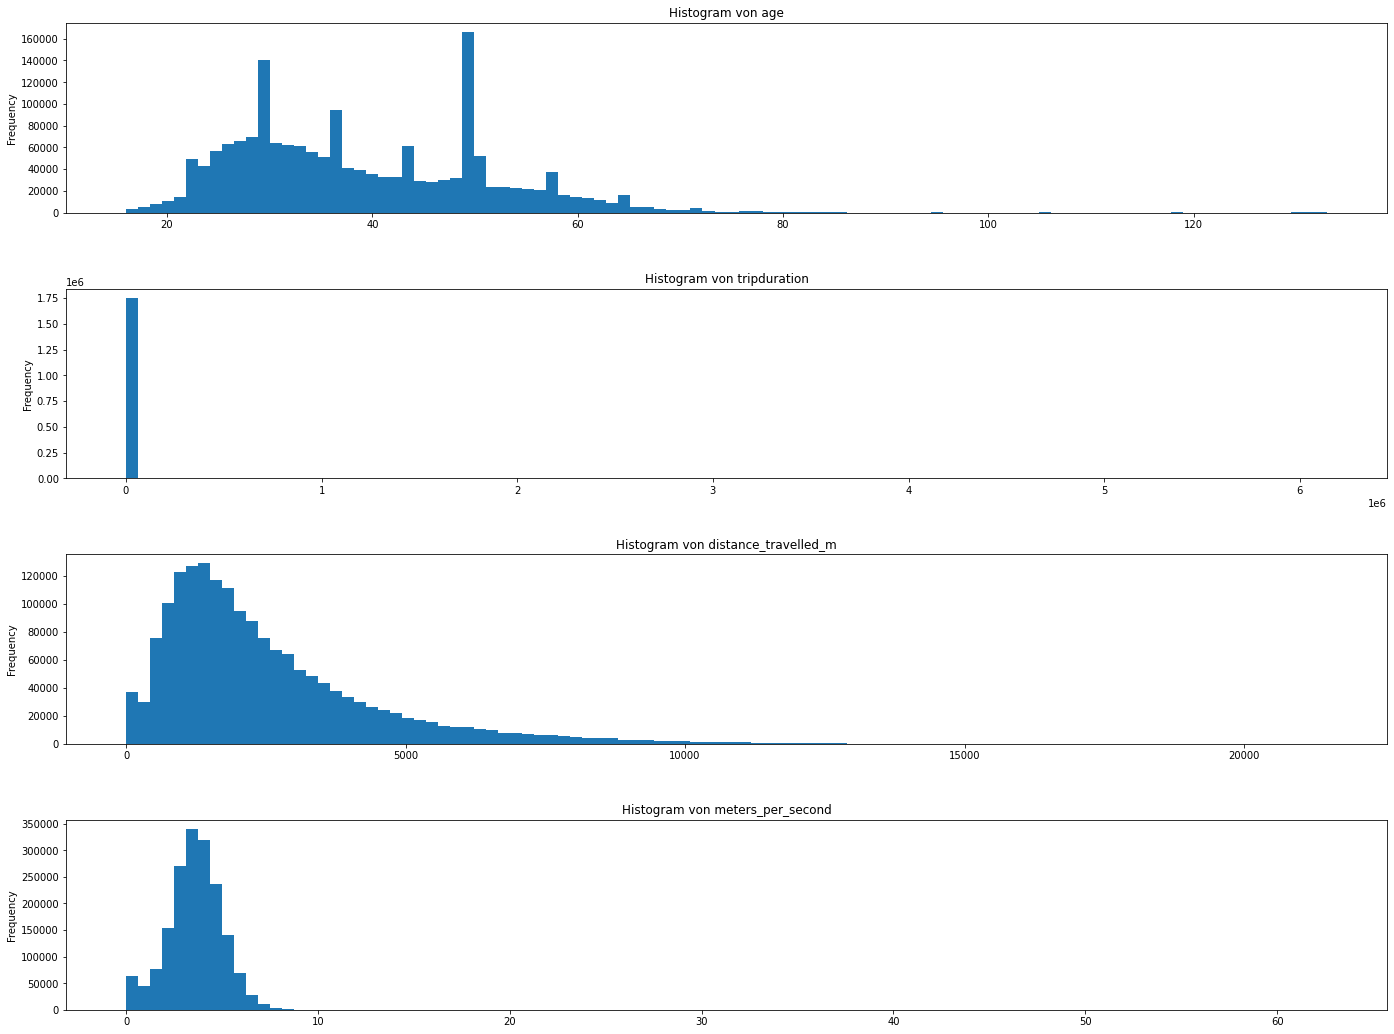

In [36]:
plt.rcParams["figure.figsize"] = (20,15)
fig, axes = plt.subplots(nrows=4, ncols=1)

for var in numeric:
  #df.sample(frac=0.1, random_state=1)[var].plot.density(ax=axes[numeric.index(var)])
  df.sample(frac=0.1, random_state=1)[var].plot.hist(ax=axes[numeric.index(var)], bins=100, title=f"Histogram von {var}")
    
    
fig.tight_layout(pad=3)

Erkentnisse:
* Die Variable Age zeigt seltsame Häufungen, speziell in der Altersgruppe um 50. Evtl. liegt es daran, dass dies der default Wert für Kunden bei der Anmeldung ist
* tripduration ist sehr links-schief, was bei der Transformation später berücksichtigt weren soll. Es scheint hier sehr große Ausreiser zu geben
* distance_travelled_m ist etwas links-schief, was bei der Transformation später berücksichtigt weren soll. Es scheint auch hier einige Ausreiser zu geben

### 3.3.4 Univariater Einfluss auf abhängige Variable

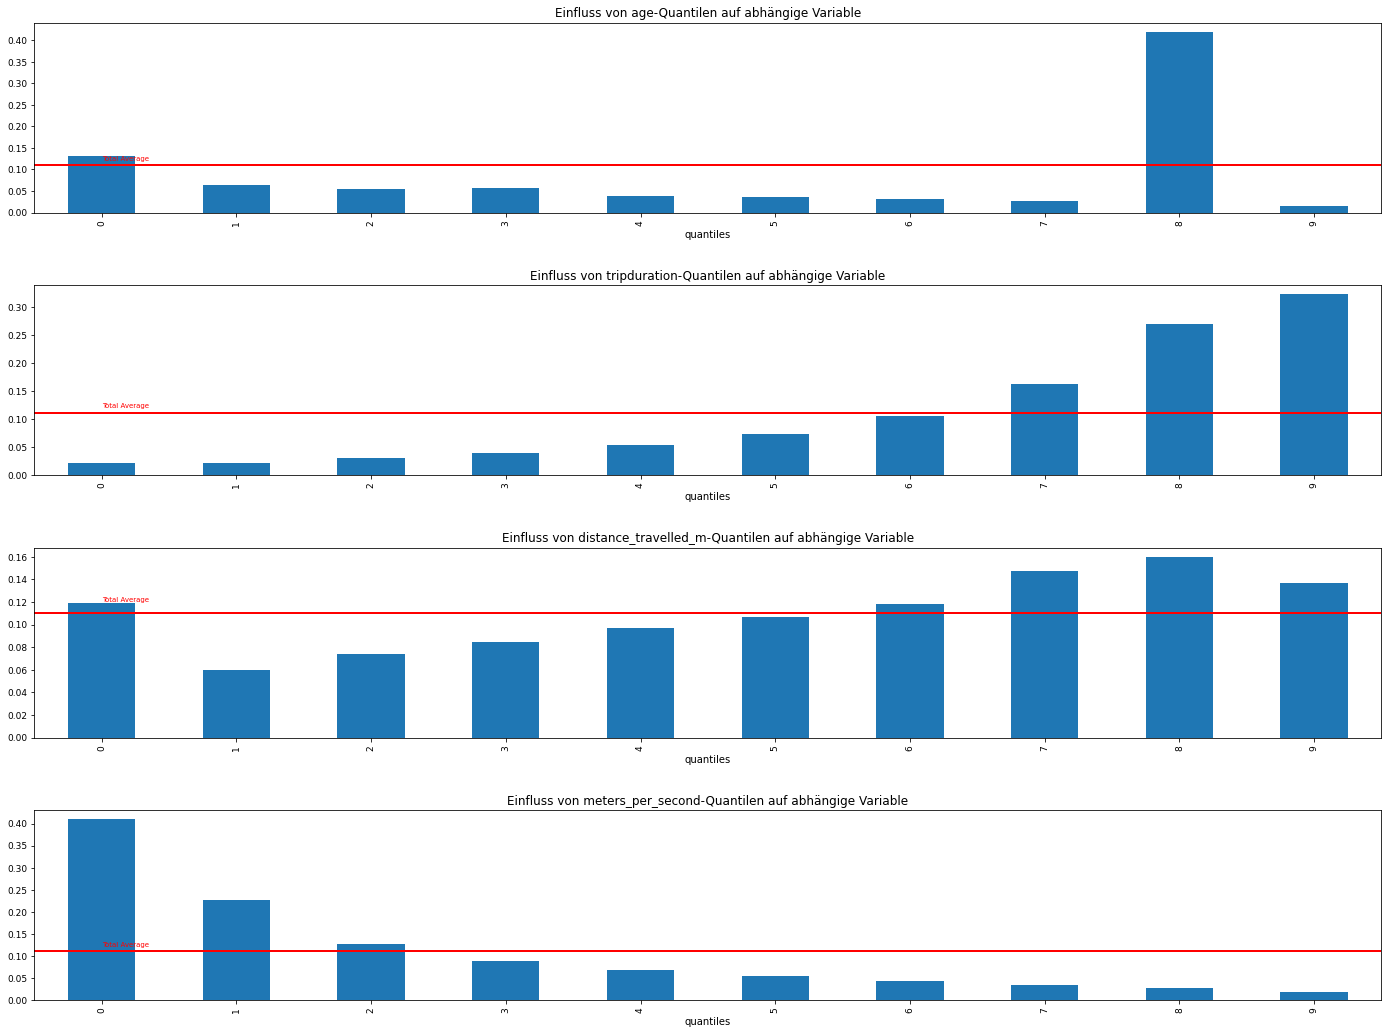

In [37]:
from sklearn.preprocessing import KBinsDiscretizer

plt.rcParams["figure.figsize"] = (20,15)
fig, axes = plt.subplots(nrows=4, ncols=1)

for var in numeric:
  QuantileDiscretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
  df["quantiles"] = QuantileDiscretizer.fit_transform(np.array(df[var]).reshape(-1, 1))
  df["quantiles"] = df["quantiles"].astype("int8")
  df.groupby("quantiles")["usertype"].mean()

  bar_plot = df.groupby("quantiles")["usertype"].mean().plot.bar(ax=axes[numeric.index(var)] , title=f"Einfluss von {var}-Quantilen auf abhängige Variable", fontsize=9)
  bar_plot.axhline(y=df["usertype"].mean(), color= 'red', linewidth=2,)
  axes[numeric.index(var)].annotate("Total Average", xy=(0, 0.12), xytext=(0, 0.12), color="red", fontsize=7)
  del df["quantiles"]

fig.tight_layout(pad=3)

Erkentnisse:
* Der starke Ausschlag bei der Variable age in Quantil 8 deutet darauf hin, dass customer ihr Alter seltener angeben und daher einen default Wert erhalten. Daneben scheinen jüngere Kunden eine leicht erhöhte Wahrscheinlichkeit zu haben customer zu sein
* Bzgl. tripduration scheint ein positiver Zusammenhang zu bestehen, d.h. customer nutzen das Bike länger als subscriber, wahrscheinlich um den 24h/3 Tages Pass auszunutzen
* Dieser positive Einfluss besteht auch bzgl. distance_travelled aber nicht so stark
* Die Geschwindigkeit hat eine negativen Korrelation mit der abhängigen Variable. Im ersten Quantil liegt das sicher daran, dass (wie oben gesehen) customer häufiger an der gleichen Station zurückgeben wo sie ausleihen, was hier zu einer Geschwindigkeit von 0 führt

# 4. Vorbereitung Modell Tests

## 4.1 Für die Modelle können einige nicht mehr benötigte Variablen gelöscht werden:

In [38]:
#meters_per_second ist bereits in "tripduration" sowie "distance_travelled_m" enthalten
del df["meters_per_second"]

#die Koordinaten der Stations werden ebenfalls nicht mehr benötigt weil diese bereits ind en station_ids und der distance_travelled_m enthalten sind
del df["start station latitude"]
del df["start station longitude"]
del df["end station latitude"]
del df["end station longitude"]


#Date muss entfernt werden, da es zu Overfitting führen würde wenn für zukünftige Zeiträume vorhergesagt werden soll
del(df["date_"])

gc.collect();

In [39]:
#Das ist nun der finale Datensatz
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   tripduration          int32  
 1   start station id      object 
 2   end station id        object 
 3   usertype              int8   
 4   gender                object 
 5   age                   int32  
 6   month                 object 
 7   weekday               object 
 8   time_hours            object 
 9   distance_travelled_m  float32
 10  same_start_end        int64  
 11  is_holiday            int8   
dtypes: float32(1), int32(2), int64(1), int8(2), object(6)
memory usage: 1.1+ GB


## 4.2 Der Datensatz wird in Test & Train Datensätze gesplitted um Hyperparameter Testing und finale Modelperformance zu testen:

Wegschreiben eines 5% samples für Hyperparameter Optimierung

In [40]:
from sklearn.model_selection import train_test_split

tol_rare_label= 5000/len(df)
#df["tol_rare_label"] = 5000/len(df)

print(tol_rare_label)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("usertype", axis=1), df["usertype"], test_size=0.95, random_state=0)

del X_test, y_test

X_train.to_parquet("X_train_hyperparemeter_opt.parquet")
pd.DataFrame(y_train).to_parquet("y_train_hyperparemeter_opt.parquet")

del X_train, y_train
gc.collect();

0.00028492725151936033


Wegschreiben eines 70/30 Test Splits für spätere Modell Evaluierung

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("usertype", axis=1), df["usertype"], test_size=0.3, random_state=0)

X_train.to_parquet("X_train.parquet")
pd.DataFrame(y_train).to_parquet("y_train.parquet")

X_test.to_parquet("X_test.parquet")
pd.DataFrame(y_test).to_parquet("y_test.parquet")

In [42]:
#Der ursprüngliche Datensatz wird nicht mehr benötigt
del df
gc.collect();

# 5 Feature Engineering Pipelines bauen

In [43]:
%%capture
! pip install feature_engine

Die Features sollen folgendermaßen für die Modelle transformiert werden

* **Diskrete Features:**
    * gender --> One Hot Encoding, Missing Values scheinen einen Informationswert zu haben und werden daher nicht ersetzt
    * start station id / end station id --> hat viele Ausprägungen und erhöht somit die Anzahl der Variablen bei OHE. Daher sollen zuerst seltene Stations gruppiert werden (Grenze nach Chart oben auf 5 Tsd. Fahrten festgelegt) und dann Mean Encoded werden. Beim Mean Encoden werden die Werte der Station mit den Mittelwerten der abhängigen Variable pro Station ersetzt)
    * same_start_end --> kann ohne Transformation verwendet werden, da es eine Dummy Variable ist
    
    
* **Zeit Features:**
    * Month/Weekday/Hour --> hier könnten sowohl One Hot Encoding als auch Mean Encoding gut funktionieren. Daher werden zwei Pielines gebaut und beide Ansätze getestet. Pipeline1 enthält diese Variablen one hot encoded und Pipeline2 mean encoded
    * Is_Holiday --> kann ohne Transformation verwendet werden, da es eine Dummy Variable ist
    
    
* **Numerische Variablen:**
    * age --> der Einfluss des Alters scheint nicht-linear zu sein und die Variable enthält Ausreiser. Daher macht eine Discretizer Transformation Sinn und die Variable wird in 10 gleich große Klassen unterteilt
    * tripduration --> enthält Ausreiser und ist nicht normal verteilt. Daher wird das 99% Quantil auf der rechten Seite abgeschnitten und anschließend der Wert logarithmiert
    * distance_travelled_m --> enthält Ausreiser und ist nicht normal verteilt. Daher wird das 99% Quantil auf der rechten Seite abgeschnitten und anschließend der Wert logarithmiert


Neben den zwei Pipelines wird noch eine Benchmark Pipeline gebaut, in welche nur die Variablen Month, Weekday & Hour einfließen


In [44]:
#Folgende Features sollen OH encoded werden
one_hot_encoding = ["gender"]

#Folgende Features sollen discretized werden
discretized = ["age"]

#Folgende Features sollen quantile geclipped werden um Ausreiser zu bereinigen, anschließend Logarithmieren
clipping_log = ["tripduration", "distance_travelled_m"]

#Für folgende Features macht eine Rare Label Zusammenfassung Sinn, da es sehr viele Features gibt:
rare_encoding = ["start station id", "end station id"]

#Folgende Features sollen frequency encoded werden
freq_encoding = ["start station id", "end station id"]

#Folgende Features sollen entweder OHE ODER frequency encodiert werden
DECISION_one_hot_or_freq = ["month", "weekday", "time_hours"]

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import FunctionTransformer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import MeanEncoder
from sklearn.impute import SimpleImputer
from feature_engine.imputation import CategoricalImputer
from sklearn.preprocessing import KBinsDiscretizer


#Alle Transformationsschritte die in SKlearn möglich sind
OneHotEncodingTransformer = OneHotEncoder(handle_unknown='ignore', drop=["unknown"], sparse=False)
QuantileDiscretizer = Pipeline(steps= [("discretizer", KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')), ("one_hot", OneHotEncoder(handle_unknown='error', drop=[0]))])
           
#Windsorizer Funktion aus feature_engine Package
windsoriser = Winsorizer(capping_method='quantiles', # choose from iqr, gaussian or quantiles
              tail='right', # cap left, right or both tails 
              fold=0.01,
              variables=clipping_log)

#Log Transformation in SKlearn, +0,01 um Fehler bei 0-Werten zu vermeiden
def log_trans(x):
    return np.log(x+0.01)
LogTransformer = FunctionTransformer(log_trans)
#LogTransformer_Tripduration = ColumnTransformer(transformers=[("log", LogTransformer, log)])


#Rare Label Encoding mit Feature Engine
rare_encoder = RareLabelEncoder(
    tol=tol_rare_label,  # minimal percentage to be considered non-rare
    n_categories=50, # minimal number of categories the variable should have to re-cgroup rare categories
    variables = rare_encoding, # variables to re-group
    replace_with="Rare"
)

#In case new stations are introduced, they will also be flagged as rare:
new_station_imputer = CategoricalImputer(variables=rare_encoding, fill_value="Rare")

#Frequency Encoding mit Feature Engine
mean_enc = MeanEncoder(variables=freq_encoding)

#Pipeline for rare:
pipeline_rare =  Pipeline([("rare", rare_encoder), ("imputer", new_station_imputer), ("encoding", mean_enc)])


#Pipeline for windsoriser & log:
pipeline_win_log =  Pipeline([("windsoriser", windsoriser), ("LogTransformer", LogTransformer)])



#Time Dimensions: OHE
OneHotEncodingTransformer2 = OneHotEncoder(handle_unknown='ignore', drop="first", sparse=False)
#OHE_time_dimensions = ColumnTransformer(transformers=[("ohe_time", OneHotEncodingTransformer2, DECISION_one_hot_or_freq)])


#Time Dimensions: Frequency Encoding mit Feature Engine
mean_enc_time = MeanEncoder(variables=DECISION_one_hot_or_freq)



#Bau der Benchmark Preprocessing Pipeline
preprocessor_benchmark = ColumnTransformer(
    transformers=[
        ("OneHotEncodingTransformer_time", OneHotEncodingTransformer2, DECISION_one_hot_or_freq),
    ],
n_jobs=-1)


#Bau der Variante 1 Preprocessing Pipeline (time Variablen OHE)
preprocessor_final_1 = ColumnTransformer(
    transformers=[
        ("only_ohe", OneHotEncodingTransformer, one_hot_encoding),
        ("quantile_discretizer", QuantileDiscretizer, discretized),
        ("windsoriser_log", pipeline_win_log, clipping_log),
        ("pipeline_rare", pipeline_rare, rare_encoding),
        ("OneHotEncodingTransformer_time", OneHotEncodingTransformer2, DECISION_one_hot_or_freq),
    ],
n_jobs=-1, remainder="passthrough")


#Bau der Variante 1 Preprocessing Pipeline (time Variablen mean encoded)
preprocessor_final_2 = ColumnTransformer(
    transformers=[
        ("only_ohe", OneHotEncodingTransformer, one_hot_encoding),
        ("quantile_discretizer", QuantileDiscretizer, discretized),
        ("windsoriser_log", pipeline_win_log, clipping_log),
        ("pipeline_rare", pipeline_rare, rare_encoding),
        ("mean_enc_time", mean_enc_time, DECISION_one_hot_or_freq),
    ],
n_jobs=-1, remainder="passthrough")



Wegschreiben der Pipelines damit sie in dieser Form in anderen Schritten verwendet und später produktiviert werden können

In [46]:
import joblib

joblib.dump(preprocessor_final_1, 'preprocessor_final_1.joblib');
joblib.dump(preprocessor_final_2, 'preprocessor_final_2.joblib');
joblib.dump(preprocessor_benchmark, 'preprocessor_benchmark.joblib');

In [47]:
#Test ob alles funktioniert
test = preprocessor_final_1.fit_transform(X_train[1:10000], y_train[1:10000])
test.shape

(9999, 57)

In [48]:
#Test ob alles funktioniert
test = preprocessor_final_2.fit_transform(X_train[1:10000], y_train[1:10000])
test.shape

(9999, 20)

In [49]:
#Test ob alles funktioniert
test = preprocessor_benchmark.fit_transform(X_train[1:10000], y_train[1:10000])
test.shape

(9999, 40)

# 6 Hyperparameter Optimierung verschiedener Modellansätze

→ Ordner **02-Hyperparamater_Tuning** enthält die Skripte für das Hyperparameter Tuning für Elasticnet logistische Regression, Random Forrest, Neuronales Netzwerk sowie LightGBM

# 7 Scoring

→ Notebook **03-Scoring_Inference** Tuning enthält die finale Modellevaluation sowie Einsatzgebiete/UseCases sowie Kooperationsmöglichkeit mit Versicherung